<table>
  <tr>
      <td><div align="left"><font size="20" >Image-based Visual Servo</font></div></td>
     <td><img src="../common/RVSS-logo.png" width="400"></td>
  </tr>
</table>

We need to import some modules. We will use the standard `numpy` package to help us with linear algebraic operations on matrices and vectors.

`common.py` is a set of specific helper functions to support these tutorials.  If you want to know what a function does, just click somewhere within the parentheses that enclose the arguments and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.

In [1]:
import numpy as np
import math
import sys
sys.path.append("../common") # common stuff
from common import *
from cam_visualizers import *

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

***
We will define the coordinates of the three vertices of an equilateral triangle, as columns of a matrix

In [2]:
P = np.array([  [-1, 0,            5],
                [ 1, 0,            5],
                [ 0, math.sqrt(3), 5]]).T
P

array([[-1.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.73205081],
       [ 5.        ,  5.        ,  5.        ]])

Instantiate a projective camera object, centred at the origin and viewing parallel to the world frame z-axis

In [3]:
camera = Camera()

Now we can project the triangle vertex points to the image plane

In [4]:
p = camera.project(P)
p

array([[340.        , 660.        , 500.        ],
       [500.        , 500.        , 777.12812921]])

the result is a matrix with one column for each image plane point for the world point in the corresponding column  (in units of pixels)

<IPython.core.display.Javascript object>


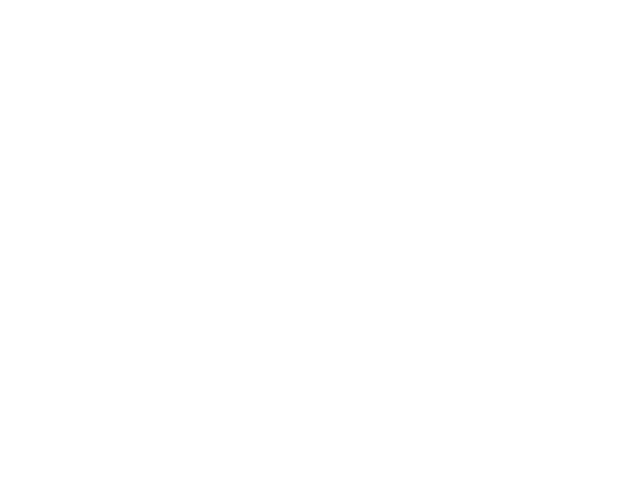

<IPython.core.display.Javascript object>


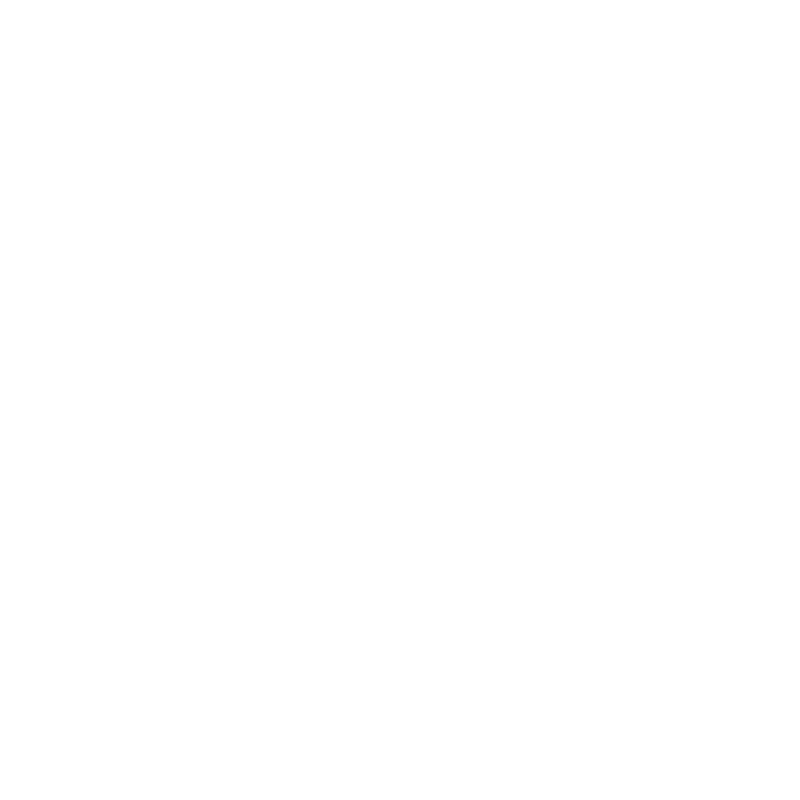

In [5]:
# setup the plot
plt.clf()
plt.figure(figsize=(8,8))
ax = plt.gca()
plt.grid(True)
ax.set_aspect('equal')
ax.set_facecolor('yellow')
plt.xlabel('u (pixels)')
plt.ylabel('v (pixels)')
plt.title('Camera image plane')
plt.xlim(0, 1000)
ax.set_ylim(1000, 0)  # inverted y-axis

plt.plot(p[0,:], p[1,:], 'o')

Now, we want the image-plane points to be somewhere else, let's choose the goal image plane coordinates

In [6]:
pstar = np.array( [
    [100,   100],
    [900,   180],
    [500,   870] ]).T

The error, between where the vertices are, and where we want them is simply

In [7]:
e = pstar - p
print(e)

[[-240.          240.            0.        ]
 [-400.         -320.           92.87187079]]


we can plot the actual image-plane positions, the desired image-plane positions and the error vectors on the one plot

<IPython.core.display.Javascript object>


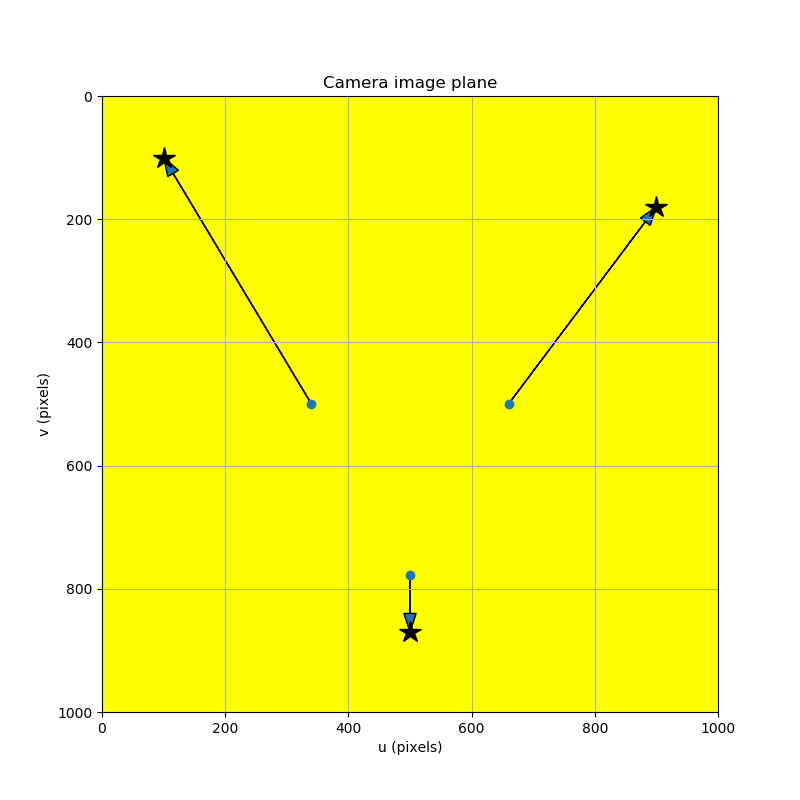

In [8]:
plt.clf()
plt.figure(figsize=(8,8))
ax = plt.gca()
plt.grid(True)
ax.set_aspect('equal')
ax.set_facecolor('yellow')
plt.xlabel('u (pixels)')
plt.ylabel('v (pixels)')
plt.title('Camera image plane')
plt.xlim(0, 1000)
ax.set_ylim(1000, 0)  # inverted y-axis

plt.plot(p[0,:], p[1,:], 'o')
plt.plot(pstar[0,:], pstar[1,:], 'k*', markersize=16)

for a,b in zip(p.T, e.T):
    plt.arrow(a[0], a[1], b[0], b[1], head_width=20, length_includes_head=True)

The image-plane velocity will be some small multiple of these error vectors

In [11]:
pdot_star = 0.01 * e.reshape((-1,1), order='F')  # turn e into a column vector with row-major ordering
pdot_star

array([[-2.4       ],
       [-4.        ],
       [ 2.4       ],
       [-3.2       ],
       [ 0.        ],
       [ 0.92871871]])

Now we can create a Jacobian matrix for the 3 points, this is a vertical stack of the $2 \times 6$ Jacobian matrices, resulting in a $6 \times 6$ matrix. `visjac` does this automatically, given N points, it will return a $2N \times 6$ Jacobian matrix.  We do need to provide an estimate of the distance to the points, here that is set to 3m for all the points.  See `Camera.visjac?` for more details.

In [12]:
Jp = camera.visjac(p, 3)
print(Jp.round(2))

[[-266.67    0.    -53.33    0.   -832.      0.  ]
 [   0.   -266.67    0.    800.      0.    160.  ]
 [-266.67    0.     53.33    0.   -832.      0.  ]
 [   0.   -266.67    0.    800.      0.   -160.  ]
 [-266.67    0.      0.      0.   -800.    277.13]
 [   0.   -266.67   92.38  896.      0.      0.  ]]


Now we invert the relationship from camera velocity to image plane, to solve for the camera velocity required given the desired image plane velocity.

In [13]:
vcam = np.linalg.inv(Jp) @ pdot_star
vcam

array([[-0.06754998],
       [ 0.02511865],
       [ 0.045     ],
       [ 0.00387288],
       [ 0.02165064],
       [-0.0025    ]])

which is the velocity the camera must have in 3D space in order to move the image to be more like that shown with the stars.  The motion is predominantly in the camera x-direction as well as some rotation about the camera's y-axis.

In [14]:
vmax = 0.015  # maximum norm of camera velocity

def vservo(camera, P, pstar, current_T, lam=0.08, Z=10):
    p = camera.project(P, T=current_T)
    e = pstar - p
    pdot_star = lam * e.reshape((-1,1), order='F')
    Jp = camera.visjac(p, Z)
    
    # limit speed of motion
    vcam = np.linalg.inv(Jp) @ pdot_star
    vn = np.linalg.norm(vcam)
    if vn > vmax:
        vcam = vcam / vn * vmax
    
    # update camera pose, we use matrix exponential to convert velocity screw to SE(3) increment
    next_T = trnorm(current_T @ trexp( vcam ))
    
    return next_T, np.linalg.norm(e)

<IPython.core.display.Javascript object>


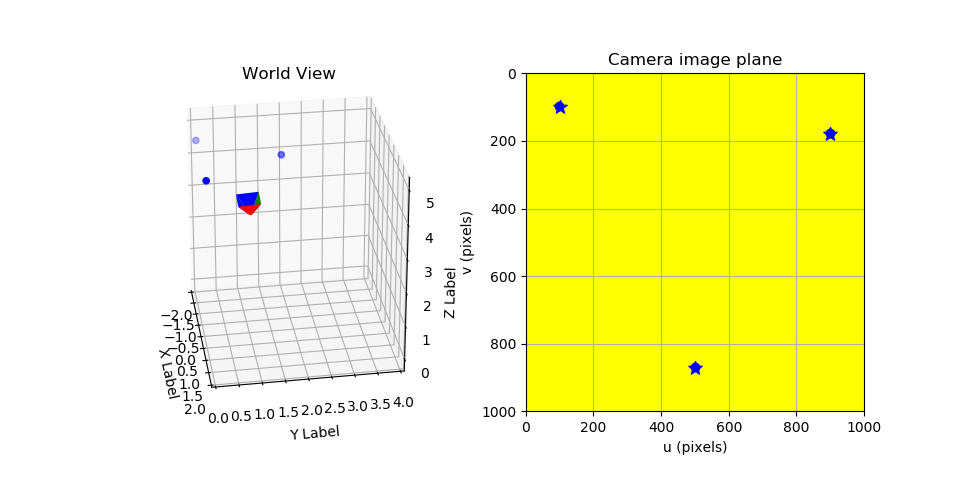

In [15]:
# Following is to reset all parameters and make the cell isolated and repeatable
# Note that initial camera pose is currently at origin looking along z axis.
camera = Camera()
P = np.array([  [-1, 0,            5],
                [ 1, 0,            5],
                [ 0, math.sqrt(3), 5]]).T
pstar = np.array( [
                  [100,   100],
                  [900,   180],
                  [500,   870] ]).T

# Set parameters for pose updating
dt = 0.05   # time step
Z = 5       # use fixed value of Z
lam = 0.2   # scalar gain

def setup():
    # Set up the 3D space to move the object and 2D plane for camera view
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax3d = fig.add_subplot(121, projection='3d')
    ax2d = fig.add_subplot(122)
    ax3d.set_xlabel('X Label')
    ax3d.set_ylabel('Y Label')
    ax3d.set_zlabel('Z Label')
    ax3d.set_title('World View')
    ax3d.set_xlim(-2,2)
    ax3d.set_ylim(0,4)
    ax2d.set_xlabel('u (pixels)')
    ax2d.set_ylabel('v (pixels)')
    ax2d.set_title('Camera image plane')
    ax2d.set_aspect('equal')
    ax2d.set_facecolor('yellow')
    ax2d.set_xlim(0, 1000)
    ax2d.set_ylim(1000, 0)  # inverted y-axis
    ax2d.grid()

    # Create the base frustum visualization
    # Top is green, right is red, other sides are blue
    cam_viz = CamVisualizer(camera, f_length=0.5, fb_width=0.05, ft_width=0.5)
    collection = Poly3DCollection(cam_viz.gen_frustrum_poly(), facecolors=['g', 'r', 'b', 'b'])
    ax3d.add_collection3d(collection)

    return fig, ax2d, ax3d, collection

fig, ax2d, ax3d, collection = setup()

# Draw points in 3d model
scat3d = ax3d.scatter(P[0], P[1], P[2], c='b')

# Draw desired points on image plane (stars)
ax2d.scatter(pstar[0], pstar[1], marker='*', s=100, c='b')

# Draw current point projections on image plane
p = camera.project(P)
scat2d = ax2d.scatter(p[0], p[1], c='b')

# Define starting error as very high to start
error = 1e6
# Error threshold tunable to see different end points
error_thresh = 5

# Generator function used in FuncAnimation to dictate when we stop (error drops below threshold)
def evaluate():
    i = 0
    while error > error_thresh:
        i += 1
        yield i
        
# Animation function used in FuncAnimation to update world and camera view images
def animate_servo(frame_id):
    # Make sure we are using the global error parameter otherwise we will never stop
    global error
    # Calculate new pose of the camera
    camera.T, error = vservo(camera, P, pstar, camera.T, lam=0.01)
    
    # Remember to update camera matrix (not done automatically)
    camera.C = camera.get_C(camera.T)
    
    # Update frustrum coordinates in world view
    cam_visualizer = CamVisualizer(camera, f_length=0.5, fb_width=0.05, ft_width=0.5)
    new_frustrum_points = cam_visualizer.gen_frustrum_poly()
    
    # update the Collection3dPoly to update the figure
    collection.set_verts(new_frustrum_points)
    
    # Update Camera View
    cam_view_points = camera.project(P).transpose()
    scat2d.set_offsets(cam_view_points)

ani = FuncAnimation(fig, animate_servo, frames=evaluate(), interval=dt*1000, 
                    blit=False, repeat=False)
plt.show()    

You can experiment with this in various ways:
* change the gain
* change the initial position of the camera
* servo to more than 3 points. In this case the Jacobian will be non-square so you will have to use the pseudo inverse